In [113]:
!pip install librosa tqdm


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm 

In [115]:
dataset = pd.read_csv('cv-valid-train.csv')
dataset 

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
195771,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,NaN
195772,cv-valid-train/sample-195772.mp3,the irish man sipped his tea,1,0,NaN,NaN,NaN,NaN
195773,cv-valid-train/sample-195773.mp3,what do you know about that,1,0,NaN,NaN,NaN,NaN
195774,cv-valid-train/sample-195774.mp3,the phone rang while she was awake,2,0,twenties,male,us,NaN


In [116]:
dataset=dataset[['filename','age' , 'gender']] 
data=dataset[dataset['age'].notna() & dataset['gender'].notna()]
data

,filename,age,gender
5,cv-valid-train/sample-000005.mp3,twenties,female
8,cv-valid-train/sample-000008.mp3,seventies,male
13,cv-valid-train/sample-000013.mp3,thirties,female
14,cv-valid-train/sample-000014.mp3,sixties,male
19,cv-valid-train/sample-000019.mp3,fifties,male
...,...,...,...
195766,cv-valid-train/sample-195766.mp3,fourties,male
195767,cv-valid-train/sample-195767.mp3,thirties,female
195770,cv-valid-train/sample-195770.mp3,twenties,male
195771,cv-valid-train/sample-195771.mp3,thirties,male


In [117]:
base_path = "/Users/vaishvikjaiswal/Dhwani4U/"

In [118]:
def trim_silence(y):
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)  
    return y_trimmed

In [119]:
def normalize_audio(y):
    peak = np.max(np.abs(y))
    if peak > 0:
        y = y / peak
    return y

In [120]:
def resample_audio(y, orig_sr, target_sr=22050):
    if orig_sr != target_sr:
        y = librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr)
    return y, target_sr


In [121]:
def calculate_snr(audio_file_path):
    try:
        y, sr = librosa.load(audio_file_path, sr=None)
        y = trim_silence(y)
        y = normalize_audio(y)
        y, sr = resample_audio(y, sr, target_sr=22050)
        
        signal_power = np.mean(y**2)
        
        noise_sample = np.percentile(np.abs(y), 20)**2
        
        if noise_sample == 0:
            return float('inf')
            
        snr = 10 * np.log10(signal_power / noise_sample)
        
        return snr
    except Exception as e:
        print(f"Error processing {audio_file_path}: {e}")
        return float('-inf')

In [122]:
def add_snr_to_dataframe(dataframe, base_path=""):
    snr_values = []
    
    print("Calculating SNR for each audio file...")
    for filename in tqdm(dataframe['filename']):
        file_path = f"{base_path}{filename}"
        snr = calculate_snr(file_path)
        snr_values.append(snr)
    
    dataframe['snr'] = snr_values
    return dataframe

In [123]:
dataset_with_snr=add_snr_to_dataframe(data, base_path)

Calculating SNR for each audio file...


100%|█████████████████████████████████████| 73466/73466 [18:42<00:00, 65.43it/s]
/var/folders/kk/18b3yzps28q_cvvqn195k0c00000gn/T/ipykernel_2294/1369059827.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['snr'] = snr_values


In [124]:
dataset_with_snr

,filename,age,gender,snr
5,cv-valid-train/sample-000005.mp3,twenties,female,28.148118
8,cv-valid-train/sample-000008.mp3,seventies,male,24.675789
13,cv-valid-train/sample-000013.mp3,thirties,female,21.138996
14,cv-valid-train/sample-000014.mp3,sixties,male,17.572991
19,cv-valid-train/sample-000019.mp3,fifties,male,18.571722
...,...,...,...,...
195766,cv-valid-train/sample-195766.mp3,fourties,male,25.085636
195767,cv-valid-train/sample-195767.mp3,thirties,female,30.945879
195770,cv-valid-train/sample-195770.mp3,twenties,male,20.318657
195771,cv-valid-train/sample-195771.mp3,thirties,male,20.912240


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


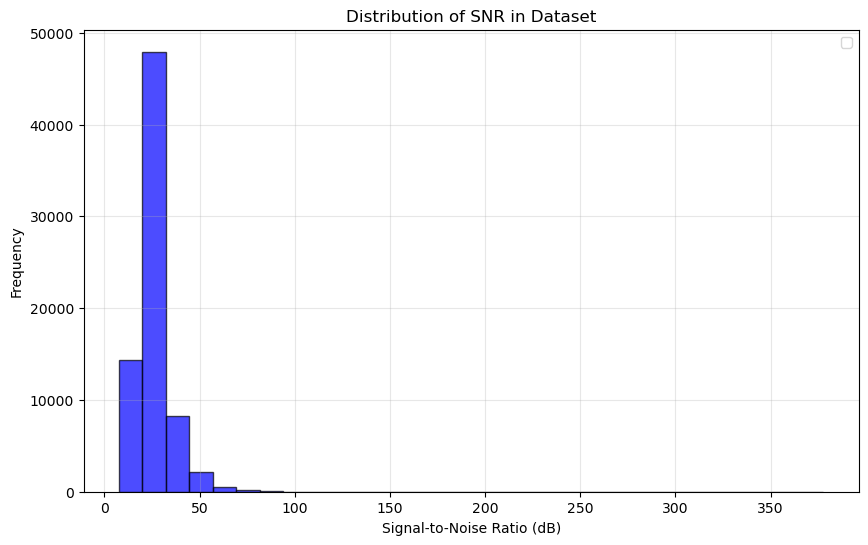

In [125]:
filtered_snr = dataset_with_snr['snr']
filtered_snr = filtered_snr.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(10, 6))
plt.hist(filtered_snr, bins=30, color='blue', alpha=0.7, edgecolor='black')

plt.xlabel('Signal-to-Noise Ratio (dB)')
plt.ylabel('Frequency')
plt.title('Distribution of SNR in Dataset')

plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [168]:
def filter_by_snr(dataset, min_threshold=10, max_threshold=60):
    filtered_df = dataset[(dataset['snr'] >= min_threshold) & (dataset['snr'] <= max_threshold)]
    
    # Calculate removed counts for both conditions
    below_min_count = len(dataset[dataset['snr'] < min_threshold])
    above_max_count = len(dataset[dataset['snr'] > max_threshold])
    total_removed = below_min_count + above_max_count
    
    print(f"Removed {below_min_count} rows ({below_min_count/len(dataset)*100:.2f}%) with SNR below {min_threshold} dB")
    print(f"Removed {above_max_count} rows ({above_max_count/len(dataset)*100:.2f}%) with SNR above {max_threshold} dB")
    print(f"Total removed: {total_removed} rows ({total_removed/len(dataset)*100:.2f}%)")
    
    return filtered_df

def process_dataset(dataset, min_snr_threshold=10, max_snr_threshold=60, base_path=""):
    filtered_dataset = filter_by_snr(dataset, min_threshold=min_snr_threshold, max_threshold=max_snr_threshold)
    
    return filtered_dataset

filtered_data = process_dataset(dataset_with_snr, min_snr_threshold=10, max_snr_threshold=60, base_path=base_path)
filtered_data

Removed 16 rows (0.02%) with SNR below 10 dB
Removed 637 rows (0.87%) with SNR above 60 dB
Total removed: 653 rows (0.89%)


,filename,age,gender,snr
5,cv-valid-train/sample-000005.mp3,twenties,female,28.148118
8,cv-valid-train/sample-000008.mp3,seventies,male,24.675789
13,cv-valid-train/sample-000013.mp3,thirties,female,21.138996
14,cv-valid-train/sample-000014.mp3,sixties,male,17.572991
19,cv-valid-train/sample-000019.mp3,fifties,male,18.571722
...,...,...,...,...
195766,cv-valid-train/sample-195766.mp3,fourties,male,25.085636
195767,cv-valid-train/sample-195767.mp3,thirties,female,30.945879
195770,cv-valid-train/sample-195770.mp3,twenties,male,20.318657
195771,cv-valid-train/sample-195771.mp3,thirties,male,20.912240


# Sampling rate- 
## 1)SR is number of samples taken from analog signal per second
## 2)for effective reproduction of original signal, sampling rate should be twice of highest frequency 

# SIgnal Power-
## means how much energy signal carries or rate of its work

In [170]:
male_count = (filtered_data['gender'] == 'male').sum()
female_count = (filtered_data['gender'] == 'female').sum()

print(f"Male samples: {male_count}")
print(f"Female samples: {female_count}")

Male samples: 54101
Female samples: 17938
